In [1]:
# This is the code for the Kaggle competition: Titanic - Machine Learning from Disaster

# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

import pandas as pd
import numpy as np

# For the linear regression part
from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

# For the neural network part
from tensorflow import keras


In [2]:
# Files to load
train_file_path = "data/train.csv"
test_file_path = "data/test.csv"

dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (891, 12)


In [3]:
test_ds_pd = pd.read_csv(test_file_path)

In [4]:
# Data preprocessing
dataset_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
dataset_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
dataset_df.info()
dataset_df.describe()

<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    str    
 4   Sex          891 non-null    str    
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    str    
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    str    
 11  Embarked     889 non-null    str    
dtypes: float64(2), int64(5), str(5)
memory usage: 83.7 KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# We see what type of data we have in the data set. We will handle them differently (onehotcoder for categorical, imputation for numerical).
list(set(dataset_df.dtypes.tolist()))

[<StringDtype(storage='python', na_value=nan)>,
 dtype('int64'),
 dtype('float64')]

In [8]:
# There are many elemnts that we should be aware of.
# First, we see that the type of variable corresponds correctly to the type of data (object for categorical, float for numerical).
summary = pd.DataFrame({
    "dtype": dataset_df.dtypes,
    "non_null": dataset_df.notna().sum(),
    "n_unique": dataset_df.nunique(dropna=True), #number of unique values, excluding NaN
})
# We display summary
display(summary)

# Things to be noted here is that for the columns 'Ticket', 'Cabin', not all elements are unique.
# We could evaluate whether having the same ticket number means equal outcomes
Ticket = dataset_df['Ticket']
Ticket_counts = Ticket.value_counts()
Ticket_counts_nuniq = Ticket_counts[Ticket_counts>1]
display("This is Ticket_counts_nuniq:", Ticket_counts_nuniq.head(7)) # We display the number of times a ticket number appeared in the dataframe

# Now we show the outcomes of the people who had the same ticket number. We expect to see a correlation, since same tickets numbers tend to mean that the passengers forms a family/friend group.
survival_by_ticket = dataset_df.groupby('Ticket')['Survived'].value_counts().unstack(fill_value=0)
tickets_with_multiple = Ticket_counts_nuniq.index.tolist()
survival_by_ticket_filtered = survival_by_ticket.loc[tickets_with_multiple]
display("This is survival_by_ticket_filtered (number of people survived for each ticket number):", survival_by_ticket_filtered.head()) # We see that indeed, there exists a relationship. Probably because members of the same group took similar actions by coordination with the rest.

# We now proceed with the smae analysis for the 'Cabin' column
Cabin = dataset_df['Cabin']
Cabin_counts = Cabin.value_counts()
Cabin_counts_nuniq = Cabin_counts[Cabin_counts>1]
display("This is Cabin_counts_nuniq:", Cabin_counts_nuniq.head(7)) # We display the number of times a cabin number appeared in the dataframe

survival_by_cabin = dataset_df.groupby('Cabin')['Survived'].value_counts().unstack(fill_value=0)
cabin_with_multiple = Cabin_counts_nuniq.index.tolist()
survival_by_cabin_filtered = survival_by_cabin.loc[cabin_with_multiple]
display("This is survival_by_cabin_filtered (number of survivor for each cabin number):", survival_by_cabin_filtered.head()) # We see that there exists a relationship.

# The question that should be asked now is, does this help training the algorithm? Or it only adds noise. For now, we will keep it.
# However, for the purely unique values, we shall group them under one column.
# In case the there is over fitting problem, it may be because there are too many columns compared to amount of rows. We could select thresholds greater than 1.
# In the end, the values that best fitted the model were the following:
max_Ticket_threshold = 3 # 1 means unique values, 2 means values that appear at most twice, etc.
max_Cabin_threshold = 1

# Tickets:
Ticket_counts_unique = Ticket_counts[Ticket_counts<=max_Ticket_threshold] # Ticket_counts[Ticket_counts==1]
tickets_with_single = Ticket_counts_unique.index.tolist()
print("This is tickets_with_single:", tickets_with_single)
dataset_df.loc[dataset_df['Ticket'].isin(tickets_with_single), 'Ticket'] = 'Other_ticket' # We group all the unique values under one column called 'Other_ticket'
display("This is the updated Ticket column:",dataset_df['Ticket'].head())

# We now do the same for Cabin:
Cabin_counts_unique = Cabin_counts[Cabin_counts<=max_Cabin_threshold]
cabin_with_single = Cabin_counts_unique.index.tolist()
print("This is cabin_with_single:", cabin_with_single)
dataset_df.loc[dataset_df['Cabin'].isin(cabin_with_single), 'Cabin'] = 'Other_cabin' # We group all the unique values under one column called 'Other_cabin'
display("This is the updated Cabin column:",dataset_df['Cabin'].head())

,dtype,non_null,n_unique
PassengerId,int64,891,891
Survived,int64,891,2
Pclass,int64,891,3
Name,str,891,891
Sex,str,891,2
Age,float64,714,88
SibSp,int64,891,7
Parch,int64,891,7
Ticket,str,891,681
Fare,float64,891,248


'This is Ticket_counts_nuniq:'

Ticket
347082      7
1601        7
CA. 2343    7
3101295     6
CA 2144     6
347088      6
382652      5
Name: count, dtype: int64

'This is survival_by_ticket_filtered (number of people survived for each ticket number):'

Survived,0,1
Ticket,,
347082,7,0
1601,2,5
CA. 2343,7,0
3101295,6,0
CA 2144,6,0


'This is Cabin_counts_nuniq:'

Cabin
G6             4
C23 C25 C27    4
B96 B98        4
F33            3
E101           3
F2             3
D              3
Name: count, dtype: int64

'This is survival_by_cabin_filtered (number of survivor for each cabin number):'

Survived,0,1
Cabin,,
G6,2,2
C23 C25 C27,2,2
B96 B98,0,4
F33,0,3
E101,0,3


This is tickets_with_single: ['347742', 'SC/Paris 2123', 'PC 17572', 'C.A. 34651', '371110', '230080', '363291', '35273', 'C.A. 31921', '110152', 'PC 17755', '110413', 'PC 17582', 'PC 17760', '13502', '239853', 'F.C.C. 13529', '29106', '345773', '248727', '24160', '113803', '237736', 'PP 9549', '239865', 'PC 17569', 'PC 17604', '113789', '345764', '2651', '11668', '349237', '113572', '36973', '2661', '248738', '364516', '3101278', 'C.A. 2315', '231919', '244367', '35281', '110465', '2665', '2627', 'PC 17558', '2668', '7534', 'PC 17593', '2678', 'STON/O2. 3101279', 'C.A. 33112', '113776', '113505', '230136', '370365', '364849', '347054', '2699', '243847', '19943', '367230', '19928', '250649', '11751', '244252', 'A/5. 3336', '370129', '230433', '113798', '250644', 'C.A. 2673', '19877', '11967', '367226', 'PC 17758', 'P/PP 3381', 'PC 17485', '11767', 'PC 17608', '36928', '16966', '111361', 'PC 17611', 'C.A. 37671', '2691', 'PC 17477', '2653', '28403', '347080', '250655', '376564', '13507'

'This is the updated Ticket column:'

0    Other_ticket
1    Other_ticket
2    Other_ticket
3    Other_ticket
4    Other_ticket
Name: Ticket, dtype: str

This is cabin_with_single: ['C85', 'E46', 'C103', 'D56', 'A6', 'B78', 'B30', 'E31', 'A5', 'D10 D12', 'C110', 'F E69', 'D47', 'B86', 'B19', 'A7', 'C49', 'A32', 'B4', 'B80', 'A31', 'D15', 'C87', 'B94', 'C99', 'C118', 'D7', 'A19', 'C106', 'E36', 'C54', 'C7', 'E34', 'C32', 'C91', 'E40', 'T', 'C128', 'D37', 'E50', 'C82', 'E10', 'A34', 'C104', 'C111', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'B79', 'D46', 'B73', 'C95', 'B38', 'B39', 'C86', 'C70', 'A16', 'C101', 'A10', 'E68', 'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'B71', 'D49', 'F G63', 'C62 C64', 'C90', 'C45', 'B101', 'D45', 'C46', 'D30', 'D11', 'E77', 'F38', 'B3', 'D6', 'B82 B84', 'A36', 'B102', 'B69', 'E49', 'C47', 'D28', 'E17', 'A24', 'C50', 'B42', 'C148']


'This is the updated Cabin column:'

0            NaN
1    Other_cabin
2            NaN
3           C123
4            NaN
Name: Cabin, dtype: str

In [9]:
from sklearn.preprocessing import FunctionTransformer
# For the 'Age' columnn, we will impute the missing values with the median in preprocessing. However, since a siginificant portion of the data is missing, it may be useful to create a new column called 'Age_missing' to indicate whether the age value was missing or not. This way, we can capture any potential information that may be lost by imputing the missing values.
#Define function to create 'Age_missing' column
def create_age_missing_column(X):
    X = X.copy() # Create a copy of the input DataFrame to avoid modifying the original data. If I wanted to modify the original data, I would modify the data right away, not using a function.
    X['Age_missing'] = X['Age'].isna().astype(int) # Create 'Age_missing' column, where 1 indicates missing age and 0 indicates non-missing age
    return X
## At the end this function proved to not be useful for improving the model, so it is unused.

# Now, there is a column called Pclass. This column is essentially cathegorical, since it refers to the ticket class, no tan actual physical magnitude.
# However, the order of 'superiority' is preserved here, where 1 refers to 'the best' and 3, 'the worst'.
# Random forest/XGBoost are based on classifying data based on thresholds (tree based models), so they can capture the order in the data and use it accurately to classify input.
# However, linear regression uses numerical operations and functions in order to fit the data. Here, the 1, 2, 3 numerical representation of the class may be innaccurate.
# We can transform the column into a categorical one by applying:
# dataset_df["Pclass"] = dataset_df["Pclass"].astype(str)
## At the end this method proved to not be impactful for improving the model, so it is unused.

In [10]:
# Second, we drop the 'PassengerId' and 'Name' columns, since they provide no value for trainning or testing.
dataset_df = dataset_df.drop(['PassengerId', 'Name'], axis=1)
test_ds_pd = test_ds_pd.drop(['PassengerId', 'Name'], axis=1)
# Final train data frame:
display("Final training data frame:",dataset_df.head(10))

'Final training data frame:'

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,Other_ticket,7.2500,NaN,S
1,1,1,female,38.0,1,0,Other_ticket,71.2833,Other_cabin,C
2,1,3,female,26.0,0,0,Other_ticket,7.9250,NaN,S
3,1,1,female,35.0,1,0,Other_ticket,53.1000,C123,S
4,0,3,male,35.0,0,0,Other_ticket,8.0500,NaN,S
5,0,3,male,NaN,0,0,Other_ticket,8.4583,NaN,Q
6,0,1,male,54.0,0,0,Other_ticket,51.8625,Other_cabin,S
7,0,3,male,2.0,3,1,349909,21.0750,NaN,S
8,1,3,female,27.0,0,2,Other_ticket,11.1333,NaN,S
9,1,2,female,14.0,1,0,Other_ticket,30.0708,NaN,C


In [11]:
# We prepare data for preprocessing.

# We separate the target variable and the features.
X = dataset_df.drop(columns=['Survived'])
print(len(X.columns))
y = dataset_df["Survived"]

# We know there are only three data types: int64, float64, and string (object).
# Select categorical columns
categorical_cols = [cname for cname in X.columns if 
                    X[cname].dtype in ["object", "category", "string"]]
print("Categorical columns:", categorical_cols)

# Select numerical columns
numerical_cols = [cname for cname in X.columns if 
                X[cname].dtype in ['int64', 'float64']]
print("Numerical columns:", numerical_cols)

# We obtain the numerical and categorical dataframes.
df_num = dataset_df[numerical_cols]
df_str = dataset_df[categorical_cols]

print(df_num.shape, df_str.shape)

9
Categorical columns: ['Sex', 'Ticket', 'Cabin', 'Embarked']
Numerical columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
(891, 5) (891, 4)


In [12]:
# We check for missing values (just for reassurance)
# We check for missing values in the Traget variable, and we check for missing values in the numerical and categorical features.
print("Number of missing values in target variable:", pd.isnull(dataset_df['Survived']).sum())
# Find missing values in the dataset 
na_counts_num = df_num.isna().sum().sort_values(ascending=False)
na_counts_str = df_str.isna().sum().sort_values(ascending=False)
#Display
missing = (na_counts_num[na_counts_num > 0]
           .to_frame("missing_count(num)"))
with pd.option_context("display.max_rows", None):
    display(missing)
missing = (na_counts_str[na_counts_str > 0]
           .to_frame("missing_count(str)"))
with pd.option_context("display.max_rows", None):
    display(missing)

# We see that there are not any more suspicious features.

Number of missing values in target variable: 0


,missing_count(num)
Age,177


,missing_count(str)
Cabin,687
Embarked,2


In [13]:
# For numerical values missing we use imputation (median), while for categorical values we use onehotencoder.
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        ))
])

# We apply the transformations to each column in a single module
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [14]:
# Data splitting

def split_dataset(dataset, test_ratio=0.30, random_state=1):
  np.random.seed(random_state)
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

# We create the dataframe we use:
X_train = train_ds_pd.drop(columns=["Survived"])
X_valid = valid_ds_pd.drop(columns=["Survived"])
y_train = train_ds_pd["Survived"]
y_valid = valid_ds_pd["Survived"]

print(X_train)

627 examples in training, 264 examples in testing.
     Pclass     Sex   Age  SibSp  Parch        Ticket     Fare        Cabin  \
0         3    male  22.0      1      0  Other_ticket   7.2500          NaN   
1         1  female  38.0      1      0  Other_ticket  71.2833  Other_cabin   
3         1  female  35.0      1      0  Other_ticket  53.1000         C123   
7         3    male   2.0      3      1        349909  21.0750          NaN   
8         3  female  27.0      0      2  Other_ticket  11.1333          NaN   
..      ...     ...   ...    ...    ...           ...      ...          ...   
884       3    male  25.0      0      0  Other_ticket   7.0500          NaN   
885       3  female  39.0      0      5        382652  29.1250          NaN   
886       2    male  27.0      0      0  Other_ticket  13.0000          NaN   
888       3  female   NaN      1      2  Other_ticket  23.4500          NaN   
889       1    male  26.0      0      0  Other_ticket  30.0000  Other_cabin   



In [15]:
# Model: neural network with batch normalization and dropout
# We now apply preprocessor to create usable datasets
# First fit it for X_train
preprocessor.fit(X_train)
# Now me transform both data set
X_train_prepro = preprocessor.transform(X_train)
X_valid_prepro = preprocessor.transform(X_valid)

# We can take a look at the feature names after preprocessing, to see how the onehotencoder transformed the categorical features.
feature_names = preprocessor.get_feature_names_out()
X_train_prepro_df = pd.DataFrame(
    X_train_prepro.toarray(),  # dense
    columns=feature_names,
    index=X_train.index
)
display(X_train_prepro_df)

# Early stopping:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Now me build our model:
shape = X_train_prepro.shape[1]

model = keras.Sequential([
    keras.layers.BatchNormalization(), # Normalize the input data
    keras.layers.Dense(256, activation='relu', input_shape=shape), # First hidden layer with 256 units and ReLU activation
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.3), # Dropout to prevent overfitting and make the network more robust
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(1, activation = 'sigmoid'), # Output layer with sigmoid activation for binary classification
])

# Remember, more layers=oferfitting problems


,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Ticket_113760,cat__Ticket_113781,cat__Ticket_1601,...,cat__Cabin_F2,cat__Cabin_F33,cat__Cabin_F4,cat__Cabin_G6,cat__Cabin_Missing,cat__Cabin_Other_cabin,cat__Embarked_C,cat__Embarked_Missing,cat__Embarked_Q,cat__Embarked_S
0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,3.0,2.0,3.0,1.0,21.0750,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,3.0,27.0,0.0,2.0,11.1333,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,3.0,25.0,0.0,0.0,7.0500,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
885,3.0,39.0,0.0,5.0,29.1250,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
886,2.0,27.0,0.0,0.0,13.0000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
888,3.0,28.0,1.0,2.0,23.4500,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


c:\Users\loren\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Maximum validation accuracy: 0.8485


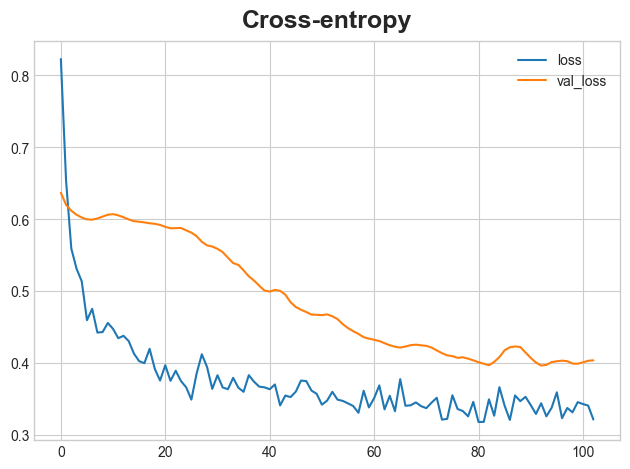

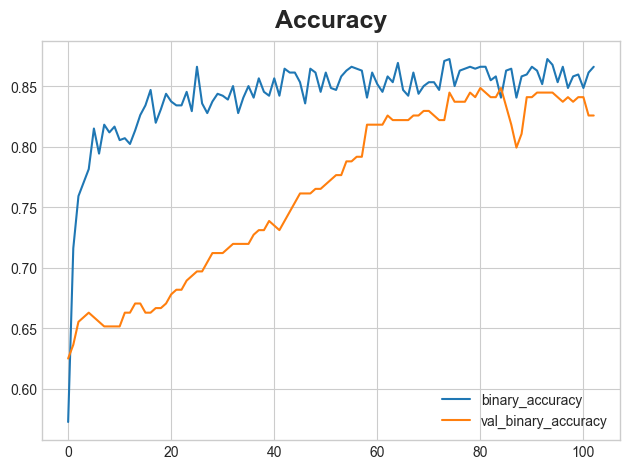

In [16]:
# We use the neural model to fit with the X_train data
model.compile(
    optimizer='adam', # Adam optimizer provides adaptive learning rate.
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    X_train_prepro, y_train,
    validation_data=(X_valid_prepro, y_valid),
    batch_size=200,
    epochs=500,
    verbose=0, # We set verbose to 0 to avoid printing the training progress for each epoch
    callbacks = [early_stopping]
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
print("Maximum validation accuracy: {:0.4f}".format(history_df['val_binary_accuracy'].max()))
plt.savefig('images/training_history.png') # Guarda la imagen
plt.show()

In [17]:
# The best model was obtained with the following parameters:
print('test_ratio:', 0.30, 'number_columns_after_preprocessing:', X_train_prepro.shape[1],'max_ticket_threshold:', max_Ticket_threshold, 'max_cabin_threshold:', max_Cabin_threshold, 'batch_size:', 100, 'number_epochs:', 200, 'activation_function:', 'elu', 'number_units:', [256, 128, 64])

test_ratio: 0.3 number_columns_after_preprocessing: 77 max_ticket_threshold: 3 max_cabin_threshold: 1 batch_size: 100 number_epochs: 200 activation_function: elu number_units: [256, 128, 64]
